In [1]:
# ==============================
# 1. Импорты и настройки
# ==============================
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Импорт для обработки текста
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Импорт для работы с изображениями
from PIL import Image
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

# Импорт для моделей из transformers
from transformers import BertTokenizer, BertModel

# Импорт для работы с PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Импорт для разделения данных и метрик
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

# Импорт skorch для обёртки PyTorch-модели
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, EpochScoring

# Устанавливаем случайное семя для воспроизводимости
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Определяем устройство: GPU (если доступно) или CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используем устройство:", device)

Используем устройство: cuda


In [3]:
# ==============================
# 2. Загрузка данных
# ==============================
# Путь к корневой папке с данными (отредактируйте по необходимости)
data_dir = "C:/Users/Deвайс/ML/to_upload"

# Пути к файлам и папкам
train_csv_path    = os.path.join(data_dir, "train_dataset.csv")
crowd_csv_path    = os.path.join(data_dir, "CrowdAnnotations.tsv")
expert_csv_path   = os.path.join(data_dir, "ExpertAnnotations.tsv")
test_csv_path     = os.path.join(data_dir, "test_queries.csv")
train_images_dir  = os.path.join(data_dir, "train_images")
test_images_dir   = os.path.join(data_dir, "test_images")

# Загрузка обучающего датасета (предполагается, что в файле есть столбцы: image, query_id, query_text)
train_df = pd.read_csv(train_csv_path)
print("Форма train_df:", train_df.shape)

# Загрузка экспертных оценок (без заголовков, задаём имена столбцов)
expert_df = pd.read_csv(expert_csv_path, sep='\t', header=None, names=['image', 'query_id', 'exp1', 'exp2', 'exp3'])
print("Форма expert_df:", expert_df.shape)

# Загрузка краудсорсинговых оценок (при необходимости, можно использовать их для комбинированной оценки)
crowd_df = pd.read_csv(crowd_csv_path, sep='\t', header=None,
                       names=['image', 'query_id', 'score', 'yes', 'no'])
print("Форма crowd_df:", crowd_df.shape)

Форма train_df: (5822, 3)
Форма expert_df: (5822, 5)
Форма crowd_df: (47830, 5)


In [4]:
# ==============================
# 3. Предобработка текста и фильтрация записей
# ==============================
# Функция первичной очистки текста: перевод в нижний регистр, удаление не буквенных символов, нормализация пробелов
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Инициализируем стоп-слова и лемматизатор
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Функция для полноценной обработки текста:
def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    # Удаляем стоп-слова и применяем лемматизацию
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return " ".join(tokens)

# Применяем обработку к столбцу с описаниями
train_df['clean_text'] = train_df['query_text'].apply(preprocess_text)

# Фильтрация записей, связанных с изображениями детей
child_words = ['child', 'boy', 'girl', 'toddler', 'baby', 'kid']
def is_child(text):
    tokens = text.split()
    return any(word in tokens for word in child_words)

# Отмечаем записи, в которых встречаются ключевые слова, связанные с детьми
train_df['is_child'] = train_df['clean_text'].apply(is_child)
print("Количество записей с упоминанием детей:", train_df['is_child'].sum())

# Исключаем такие записи (так как они могут подпадать под юридические ограничения)
train_df = train_df[~train_df['is_child']].copy()
print("Форма train_df после фильтрации:", train_df.shape)


Количество записей с упоминанием детей: 1557
Форма train_df после фильтрации: (4265, 5)


In [5]:
# ==============================
# 4. Объединение оценок (используем экспертные оценки)
# ==============================
# Рассчитаем среднюю оценку экспертов для каждой пары
expert_df['mean_exp'] = expert_df[['exp1', 'exp2', 'exp3']].mean(axis=1)
# Приведём оценки из шкалы 1–4 к шкале 0–1: (score - 1) / 3
expert_df['normalized_exp'] = (expert_df['mean_exp'] - 1) / 3.0

# Объединяем обучающий датасет с экспертными оценками по полям image и query_id
merged_df = pd.merge(train_df, expert_df[['image', 'query_id', 'normalized_exp']],
                     on=['image', 'query_id'], how='inner')
print("Форма объединённого датасета:", merged_df.shape)

# Целевая переменная – нормированная экспертная оценка
merged_df['target'] = merged_df['normalized_exp']


Форма объединённого датасета: (4265, 6)


In [6]:
# ==============================
# 5. Векторизация текстов и изображений
# ==============================
# 5.1. Векторизация текстов с помощью BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

def extract_text_features(text):
    # Токенизируем текст с ограничением длины (max_length=128)
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    # Переносим все входы на устройство (GPU/CPU)
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Извлекаем эмбеддинг токена [CLS]
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze(0).cpu().numpy()

# 5.2. Векторизация изображений с помощью ResNet18
resnet_weights = ResNet18_Weights.IMAGENET1K_V1
resnet_model = resnet18(weights=resnet_weights)
# Убираем последний полносвязный слой
modules = list(resnet_model.children())[:-1]
resnet_model = nn.Sequential(*modules).to(device)
resnet_model.eval()

# Определяем преобразования для изображений
image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_image_features(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Ошибка загрузки {image_path}: {e}")
        return None
    image_tensor = image_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet_model(image_tensor)
    # Приводим к вектору (размер 512)
    features = features.view(features.size(0), -1)
    return features.squeeze(0).cpu().numpy()


In [7]:
# ==============================
# 6. Вычисление и сохранение эмбеддингов
# ==============================
# Чтобы не вычислять эмбеддинги каждый раз, сохраняем их в файлы
features_file = os.path.join(data_dir, "features.npy")
labels_file   = os.path.join(data_dir, "labels.npy")
groups_file   = os.path.join(data_dir, "groups.npy")

if os.path.exists(features_file) and os.path.exists(labels_file) and os.path.exists(groups_file):
    print("Найдены сохранённые эмбеддинги. Загружаем их...")
    X = np.load(features_file)
    y = np.load(labels_file)
    groups = np.load(groups_file)
    print("Размер матрицы признаков:", X.shape)
else:
    print("Сохранённых эмбеддингов не найдено. Начинается вычисление...")
    X_list = []
    y_list = []
    groups_list = []
    from tqdm import tqdm
    # Проходим по всем строкам объединённого датасета
    for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Вычисление эмбеддингов"):
        # Формируем путь к изображению
        img_path = os.path.join(train_images_dir, row["image"])
        img_feat = extract_image_features(img_path)
        if img_feat is None:
            continue  # если изображение не загрузилось, пропускаем
        # Извлекаем эмбеддинг текста
        txt_feat = extract_text_features(row["clean_text"])
        # Объединяем два вектора (512 + 768 = 1280)
        combined_feat = np.concatenate([img_feat, txt_feat])
        X_list.append(combined_feat)
        y_list.append(row["target"])
        groups_list.append(row["image"])  # используем имя изображения для группировки
    X = np.array(X_list)
    y = np.array(y_list).reshape(-1, 1)
    groups = np.array(groups_list)
    print("Размер матрицы признаков:", X.shape)
    # Сохраняем вычисленные эмбеддинги
    np.save(features_file, X)
    np.save(labels_file, y)
    np.save(groups_file, groups)

Найдены сохранённые эмбеддинги. Загружаем их...
Размер матрицы признаков: (4265, 1280)


In [8]:
# ==============================
# 7. Разбиение данных на обучающую и валидационную выборки
# ==============================
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=RANDOM_SEED)
train_idx, valid_idx = next(gss.split(X, y, groups=groups))
X_train, X_valid = X[train_idx], X[valid_idx]
y_train, y_valid = y[train_idx], y[valid_idx]
print("Размер обучающей выборки:", X_train.shape)
print("Размер валидационной выборки:", X_valid.shape)

# Приводим типы данных к float32 (для PyTorch)
X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_valid = y_valid.astype(np.float32)

Размер обучающей выборки: (3426, 1280)
Размер валидационной выборки: (839, 1280)


In [9]:
# ==============================
# 8. Определение модели и обучение с использованием skorch
# ==============================
# Определяем нейронную сеть для регрессии с приведением выхода к размерности (batch_size,)
class RegressionNet(nn.Module):
    def __init__(self, input_dim=1280):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(1024, 512)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(512, 256)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(256, 64)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)
        
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        # Приводим выход к форме (batch_size,), чтобы он совпадал с целевыми значениями
        return x.view(-1)

# Функция для вычисления RMSE, которая теперь принимает три аргумента (net, X, y)
def rmse_score(net, X, y):
    # Получаем предсказания с помощью метода net.predict, который возвращает numpy-массив
    y_pred = net.predict(X)
    return sqrt(mean_squared_error(y, y_pred))

# Оборачиваем нашу модель в NeuralNetRegressor от skorch для удобства обучения
net = NeuralNetRegressor(
    module=RegressionNet,
    module__input_dim=1280,
    max_epochs=100,
    lr=0.001,
    batch_size=32,
    optimizer=optim.Adam,
    criterion=nn.MSELoss,
    callbacks=[
        EarlyStopping(patience=10),
        # Передаём нашу функцию rmse_score, которая теперь соответствует требованиям skorch
        EpochScoring(scoring=rmse_score, lower_is_better=True, on_train=True, name='train_rmse')
    ],
    device=device,  # передаём устройство (GPU/CPU)
    verbose=1
)

# Обучаем модель. При этом мы передаём целевые значения в виде плоского массива
print("Начало обучения модели...")
net.fit(X_train, y_train.ravel())

# Предсказываем на валидационной выборке
y_pred = net.predict(X_valid)
val_rmse = rmse_score(net, X_valid, y_valid)
print("Validation RMSE:", val_rmse)

Начало обучения модели...
  epoch    train_loss    train_rmse    valid_loss     dur
-------  ------------  ------------  ------------  ------
      1        0.0755        0.2747        0.0861  0.3724
      2        0.0707        0.2659        0.0694  0.2387
      3        0.0653        0.2556        0.0634  0.2336
      4        0.0607        0.2464        0.0674  0.2352
      5        0.0580        0.2408        0.0650  0.2374
      6        0.0552        0.2350        0.0564  0.2366
      7        0.0527        0.2295        0.0573  0.2367
      8        0.0548        0.2341        0.0556  0.2348
      9        0.0510        0.2259        0.0571  0.2342
     10        0.0498        0.2231        0.0570  0.2385
     11        0.0476        0.2183        0.0645  0.2346
     12        0.0473        0.2175        0.0590  0.2345
     13        0.0438        0.2093        0.0577  0.2372
     14        0.0413        0.2033        0.0595  0.2365
     15        0.0384        0.1959        0.0

In [13]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.nn.utils.rnn import pad_sequence

# --- ПАРАМЕТРЫ И ПУТИ ---
# Путь к корневой папке с данными (отредактируйте по необходимости)
data_dir = "C:/Users/Deвайс/ML/to_upload"
# Путь к тестовым изображениям (убедитесь, что такая папка существует)
test_images_dir = os.path.join(data_dir, "test_images")
# Файл для сохранения эмбеддингов тестовых изображений
test_features_file = os.path.join(data_dir, "test_features.npy")

# Список слов, связанных с детьми (для юридической фильтрации)
child_words = ['child', 'boy', 'girl', 'toddler', 'baby', 'kid']

# --- Векторизация тестовых изображений ---
# Если ранее эмбеддинги тестовых изображений были сохранены, загружаем их.
if os.path.exists(test_features_file):
    print("Загружаем сохранённые эмбеддинги тестовых изображений...")
    test_vectors = np.load(test_features_file)
    # Получаем список имён файлов тестовых изображений
    test_images_list = np.array(os.listdir(test_images_dir))
else:
    print("Вычисляем эмбеддинги тестовых изображений...")
    # Список имён тестовых изображений (предполагается, что имя файла хранится в столбце 'image' тестового датасета)
    test_images_list = np.array(os.listdir(test_images_dir))
    test_vectors_list = []
    for image_name in tqdm(test_images_list, desc="Векторизация тестовых изображений"):
        image_path = os.path.join(test_images_dir, image_name)
        vec = extract_image_features(image_path)  # функция должна возвращать вектор размерности 512
        if vec is None:
            # Если изображение не загрузилось, запишем нулевой вектор
            vec = np.zeros(512, dtype=np.float32)
        test_vectors_list.append(vec)
    test_vectors = np.array(test_vectors_list)
    np.save(test_features_file, test_vectors)
    
# Создаём DataFrame для тестовых изображений
test_df_vectors = pd.DataFrame({
    'image': test_images_list,
    'image_vector': list(test_vectors)  # Каждый элемент – вектор (512,)
})
print("Векторизация тестовых изображений завершена. Размер матрицы:", test_df_vectors.shape)

# --- Функция для получения текстового эмбеддинга ---
def get_text_embedding(input_text):
    """
    Принимает текстовый запрос, использует функцию extract_text_features для получения векторного представления.
    Возвращает вектор длины 768.
    """
    # Можно применить ту же обработку, что и для обучающих данных (если требуется)
    text_embedding = extract_text_features(input_text)  # функция должна возвращать вектор (768,)
    return text_embedding

# --- Функция для тестирования (определение наиболее релевантного изображения) ---
def imag_test(query_text):
    """
    Принимает текстовый запрос, вычисляет его эмбеддинг, для каждого тестового изображения объединяет (конкатенирует)
    эмбеддинг изображения (512) и текстовый эмбеддинг (768) в один вектор (1280).
    Затем пропускает полученную матрицу через обученную модель (net) и выбирает изображение с максимальным значением.
    Возвращает (max_score, best_image_name).
    """
    text_embedding = get_text_embedding(query_text)  # вектор (768,)
    # Для каждого тестового изображения объединяем вектор изображения и текстовый эмбеддинг по оси признаков
    test_df_vectors['combined'] = test_df_vectors['image_vector'].apply(
        lambda img_vec: np.concatenate([img_vec, text_embedding]).astype(np.float32)
    )
    # Создаём 2D-массив из объединённых векторов
    combined_array = np.stack(test_df_vectors['combined'].to_numpy())  # shape: (num_test_images, 1280)
    # Преобразуем в тензор (для модели skorch, наша модель принимает numpy-массивы, но можно использовать и torch.tensor)
    X_test_tensor = combined_array  # Если модель обучалась на np.float32, передаём numpy-массив
    # Получаем предсказания от модели (чем выше значение – тем лучше соответствие)
    predictions = net.predict(X_test_tensor)  # net — наш обученный регрессор
    test_df_vectors['pred'] = predictions
    # Находим изображение с максимальным значением предсказания
    best_idx = test_df_vectors['pred'].idxmax()
    best_score = test_df_vectors.loc[best_idx, 'pred']
    best_image = test_df_vectors.loc[best_idx, 'image']
    return best_score, best_image

# --- Функция для вывода изображения по текстовому запросу ---
def display_image_with_caption(query_text):
    """
    Если в запросе встречаются слова, связанные с детьми, выводится сообщение о недоступности изображения.
    Иначе, по запросу определяется наиболее релевантное изображение, выводится с подписью и печатается мера соответствия.
    """
    # Приводим текст запроса к нижнему регистру для проверки
    query_lower = query_text.lower()
    if any(word in query_lower for word in child_words):
        print(query_text)
        print("Изображение не доступно в данном регионе")
    else:
        max_score, best_image = imag_test(query_text)
        # Формируем путь к изображению
        image_path = os.path.join(test_images_dir, best_image)
        try:
            img = Image.open(image_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis("off")
            plt.title(query_text, fontsize=12)
            plt.show()
            print(f"Мера соответствия изображения: {max_score}")
        except Exception as e:
            print(f"Ошибка открытия изображения {image_path}: {e}")


Загружаем сохранённые эмбеддинги тестовых изображений...
Векторизация тестовых изображений завершена. Размер матрицы: (101, 2)


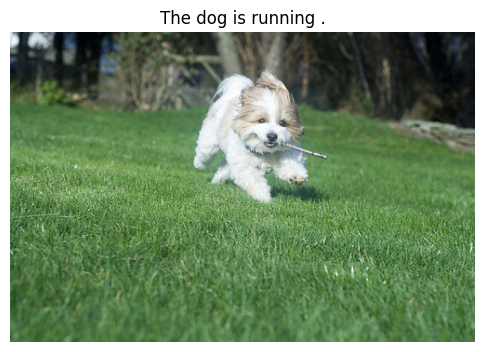

Мера соответствия изображения: 0.4242936968803406


In [14]:
# --- Пример использования ---
# Например, тестируем запрос "The dog is running ."
display_image_with_caption('The dog is running .')


In [15]:
display_image_with_caption('A group of girls who are gothically dressed standing together')

A group of girls who are gothically dressed standing together
Изображение не доступно в данном регионе


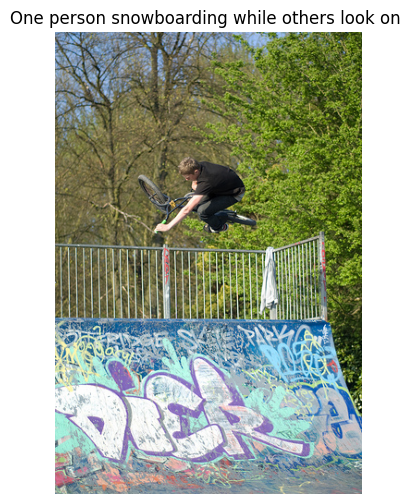

Мера соответствия изображения: 0.3973216712474823


In [16]:
display_image_with_caption('One person snowboarding while others look on ')

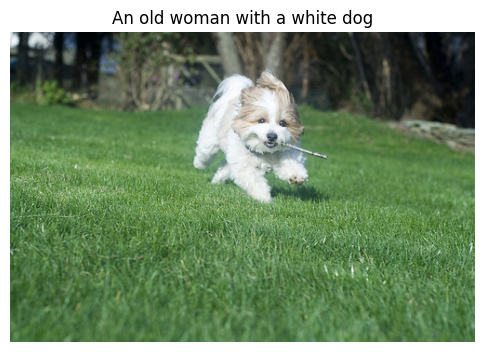

Мера соответствия изображения: 0.4659140408039093


In [18]:
display_image_with_caption('An old woman with a white dog')

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

C:\Users\Deвайс\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Deвайс\.cache\huggingface\hub\models--sentence-transformers--clip-ViT-B-32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Вычисляем эмбеддинги тестовых изображений...


Векторизация изображений:   3%|█▋                                                      | 3/101 [00:00<00:04, 24.30it/s]

Ошибка загрузки .DS_Store: cannot identify image file 'C:/Users/Deвайс/ML/to_upload\\test_images\\.DS_Store'


Векторизация изображений: 100%|██████████████████████████████████████████████████████| 101/101 [00:02<00:00, 38.31it/s]


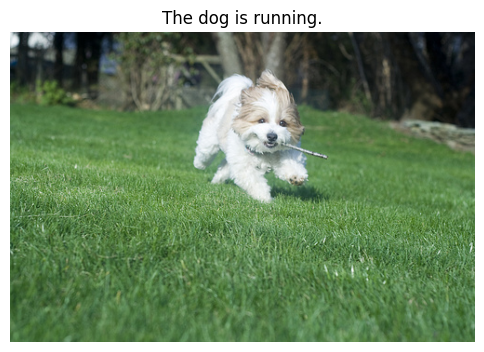

Мера соответствия (cosine similarity): 0.2842


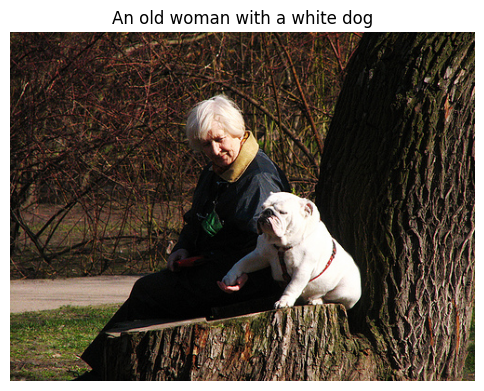

Мера соответствия (cosine similarity): 0.3322


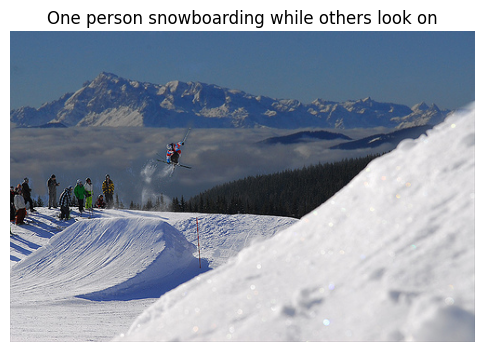

Мера соответствия (cosine similarity): 0.2826


In [21]:
# ======================================================
# 1. Импорт необходимых библиотек и настройка
# ======================================================
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Импорт модели SentenceTransformer и утилиты для вычисления косинусного сходства
from sentence_transformers import SentenceTransformer, util

# Пути (отредактируйте их под вашу файловую структуру)
data_dir = "C:/Users/Deвайс/ML/to_upload"
test_images_path = os.path.join(data_dir, "test_images")

# Список слов, связанных с изображениями детей (для юридической фильтрации)
child_words = ['child', 'boy', 'girl', 'toddler', 'baby', 'kid']

# ======================================================
# 2. Загрузка предобученной модели для векторизации
# ======================================================
# Эта модель умеет встраивать как изображения, так и текст в общее векторное пространство
clip_model = SentenceTransformer('clip-ViT-B-32')

# ======================================================
# 3. Векторизация тестовых изображений
# ======================================================
# Получаем список имён файлов тестовых изображений
test_image_files = sorted(os.listdir(test_images_path))

# Файл, в который будут сохранены эмбеддинги тестовых изображений, чтобы не вычислять их повторно
test_emb_file = os.path.join(data_dir, "test_image_embeddings.npy")

if os.path.exists(test_emb_file):
    print("Загружаем сохранённые эмбеддинги тестовых изображений...")
    test_image_embeddings = np.load(test_emb_file)
else:
    print("Вычисляем эмбеддинги тестовых изображений...")
    test_image_embeddings = []
    for fname in tqdm(test_image_files, desc="Векторизация изображений"):
        image_path = os.path.join(test_images_path, fname)
        try:
            img = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Ошибка загрузки {fname}: {e}")
            # Если изображение не удалось загрузить, используем нулевой вектор
            img = Image.new("RGB", (224, 224))
        # Получаем эмбеддинг изображения (модель сама обрабатывает вход)
        emb = clip_model.encode(img)
        test_image_embeddings.append(emb)
    test_image_embeddings = np.array(test_image_embeddings)
    np.save(test_emb_file, test_image_embeddings)

# Формируем DataFrame, где каждому файлу сопоставлен его эмбеддинг
df_test = pd.DataFrame({
    "filename": test_image_files,
    "embedding": list(test_image_embeddings)
})

# ======================================================
# 4. Функции для векторизации текста и поиска изображений
# ======================================================
def embed_query_text(query: str) -> np.ndarray:
    """
    Получает текстовый запрос и возвращает его эмбеддинг с использованием модели CLIP.
    Размерность эмбеддинга обычно 768.
    """
    return clip_model.encode(query)

def find_best_image(query: str):
    """
    Для заданного текстового запроса:
      - Вычисляется его эмбеддинг.
      - Для каждого тестового изображения рассчитывается косинусное сходство между
        текстовым эмбеддингом и эмбеддингом изображения.
      - Выбирается изображение с максимальным значением сходства.
    
    Возвращает имя файла с изображением и значение сходства.
    """
    # Вычисляем вектор для запроса
    query_emb = embed_query_text(query)
    similarities = []
    # Для каждого эмбеддинга изображения вычисляем косинусное сходство
    for img_emb in df_test["embedding"]:
        sim = util.cos_sim(query_emb, img_emb).item()
        similarities.append(sim)
    df_test["similarity"] = similarities
    # Находим индекс максимального сходства
    best_idx = df_test["similarity"].idxmax()
    best_file = df_test.loc[best_idx, "filename"]
    best_score = df_test.loc[best_idx, "similarity"]
    return best_file, best_score

def display_image_with_caption(query: str):
    """
    Если в запросе содержатся слова, связанные с детьми, выводится сообщение,
    что изображение недоступно. Иначе, по запросу ищется наиболее похожее изображение,
    выводится на экран с подписью и печатается значение косинусного сходства.
    """
    # Приводим запрос к нижнему регистру для проверки
    query_lower = query.lower()
    if any(word in query_lower for word in child_words):
        print(query)
        print("Изображение недоступно в данном регионе.")
    else:
        best_file, score = find_best_image(query)
        image_path = os.path.join(test_images_path, best_file)
        try:
            img = Image.open(image_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis("off")
            plt.title(query, fontsize=12)
            plt.show()
            print(f"Мера соответствия (cosine similarity): {score:.4f}")
        except Exception as e:
            print(f"Ошибка открытия изображения {image_path}: {e}")

# ======================================================
# 5. Примеры тестирования
# ======================================================
# Пример 1: тестовый запрос из файла тестовых запросов (если у вас есть DataFrame test_df, можно выбрать случайное значение)
# Например, если test_df имеет столбец 'query_text':
# sample_query = test_df.sample(n=1, random_state=RANDOM_SEED)['query_text'].values[0]
# display_image_with_caption(sample_query)

# Пример 2: явные тестовые запросы
display_image_with_caption("The dog is running.")
display_image_with_caption("An old woman with a white dog")
display_image_with_caption("One person snowboarding while others look on")


Размер тестового набора запросов: (500, 4)
Случайно выбранные запросы:
361    A group of girls who are gothically dressed st...
73     A woman and girl riding downhill on a sled wit...
374                                 The dog is running .
155    A group of people are ice skating in a big city .
104    Little kid in blue coat and hat riding a tricy...
394         Two black dogs fighting over an orange toy .
377        A dog jumping for a tennis ball near an ocean
124                          Boy flying a distant kite .
68                          kids play ultimate Frisbee .
450               A girl in a purple shirt feeding ducks
Name: query_text, dtype: object

Запрос 362: A group of girls who are gothically dressed standing together
A group of girls who are gothically dressed standing together
Изображение недоступно в данном регионе.

Запрос 74: A woman and girl riding downhill on a sled with a dog running alongside them
A woman and girl riding downhill on a sled with a dog runnin

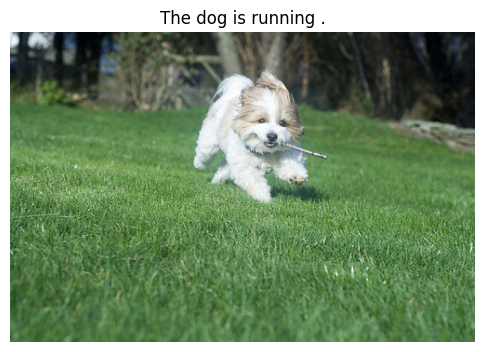

Мера соответствия (cosine similarity): 0.2842

Запрос 156: A group of people are ice skating in a big city .


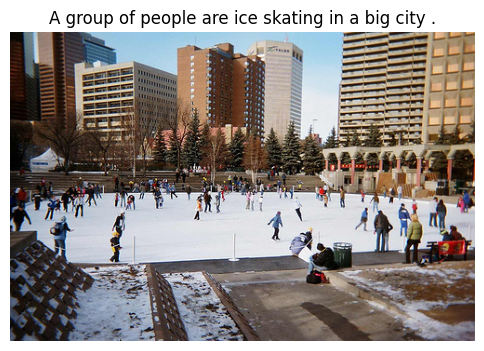

Мера соответствия (cosine similarity): 0.3124

Запрос 105: Little kid in blue coat and hat riding a tricycle .
Little kid in blue coat and hat riding a tricycle .
Изображение недоступно в данном регионе.

Запрос 395: Two black dogs fighting over an orange toy .


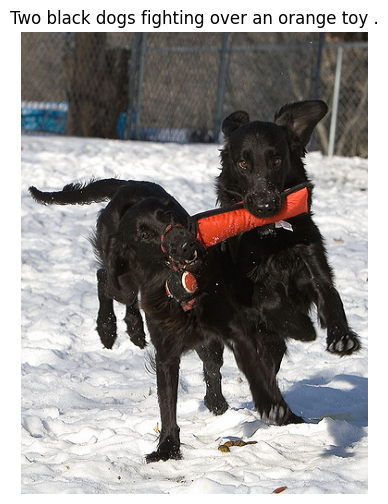

Мера соответствия (cosine similarity): 0.3502

Запрос 378: A dog jumping for a tennis ball near an ocean


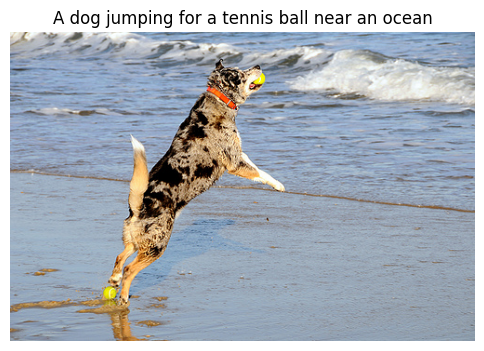

Мера соответствия (cosine similarity): 0.3339

Запрос 125: Boy flying a distant kite .
Boy flying a distant kite .
Изображение недоступно в данном регионе.

Запрос 69: kids play ultimate Frisbee .
kids play ultimate Frisbee .
Изображение недоступно в данном регионе.

Запрос 451: A girl in a purple shirt feeding ducks
A girl in a purple shirt feeding ducks
Изображение недоступно в данном регионе.


In [25]:
# =============================================================================
# 9. Тестирование модели: 10 случайных запросов из тестового набора
# =============================================================================

# Путь к файлу с тестовыми запросами (отредактируйте, если необходимо)
test_queries_file = os.path.join(data_dir, "test_queries.csv")

# Загрузка тестовых запросов; настройте параметр sep, если требуется (например, sep='|' или sep=',')
df_queries = pd.read_csv(test_queries_file, sep='|')  # предполагается, что столбец называется "query_text"
print("Размер тестового набора запросов:", df_queries.shape)

# Выбираем 10 случайных запросов с фиксированным семенем для воспроизводимости
random_queries = df_queries.sample(n=10, random_state=RANDOM_SEED)
print("Случайно выбранные запросы:")
print(random_queries["query_text"])

# Для каждого запроса выводим изображение с подписью и мерой соответствия
for idx, row in random_queries.iterrows():
    query_text = row["query_text"]
    print(f"\nЗапрос {idx+1}: {query_text}")
    display_image_with_caption(query_text)
